<a href="https://www.kaggle.com/code/dscleo/predicting-road-accident-risk?scriptVersionId=269790819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Metric: Root Mean Squared Error

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
X = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

In [4]:
X

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


# EDA

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

<Axes: xlabel='accident_risk', ylabel='Density'>

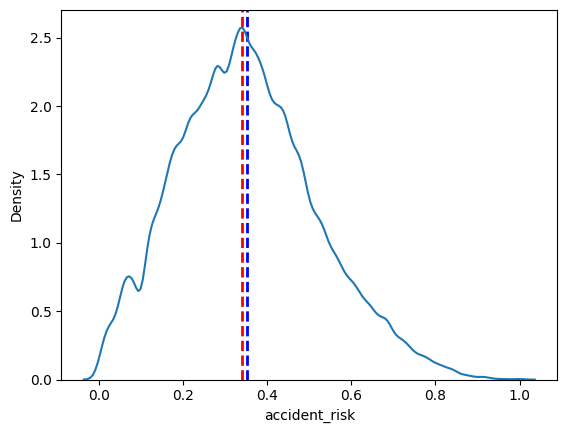

In [6]:
median = X["accident_risk"].median()
mean = X["accident_risk"].mean()
plt.axvline(median, color='red', linestyle='dashed', linewidth=2)
plt.axvline(mean, color='blue', linestyle='dashed', linewidth=2)
sns.kdeplot(X["accident_risk"])

In [7]:
X["lighting"].value_counts()

lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of accident risk according to lighting')

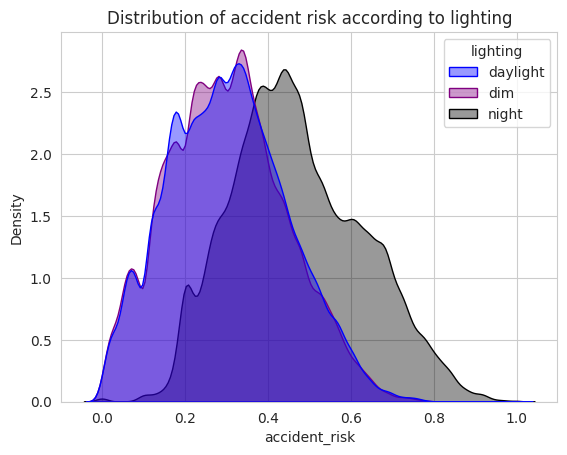

In [8]:
sns.set_style("whitegrid")
sns.kdeplot(
    data=X,
    x="accident_risk",
    hue="lighting",
    palette={"daylight": "blue", "dim": "purple", "night": "black"},
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Distribution of accident risk according to lighting")

In [9]:
X["weather"].value_counts()

weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of accident risk according to weather')

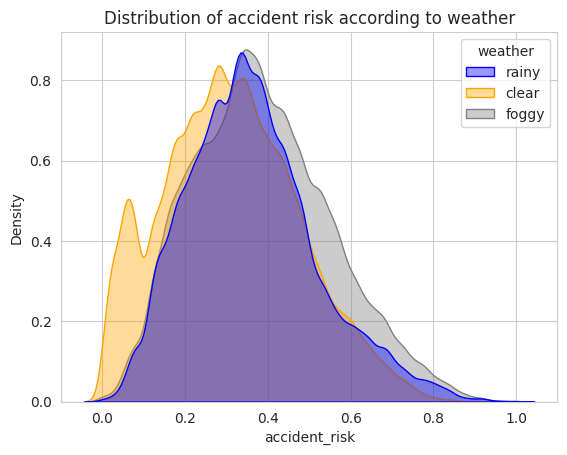

In [10]:
sns.kdeplot(
    data=X,
    x="accident_risk",
    hue="weather",
    palette={"foggy": "grey", "clear": "orange", "rainy": "blue"},
    fill=True,
    alpha=0.4
)
plt.title("Distribution of accident risk according to weather")

In [11]:
numerical_columns = X.select_dtypes(include = "number").columns

<Axes: >

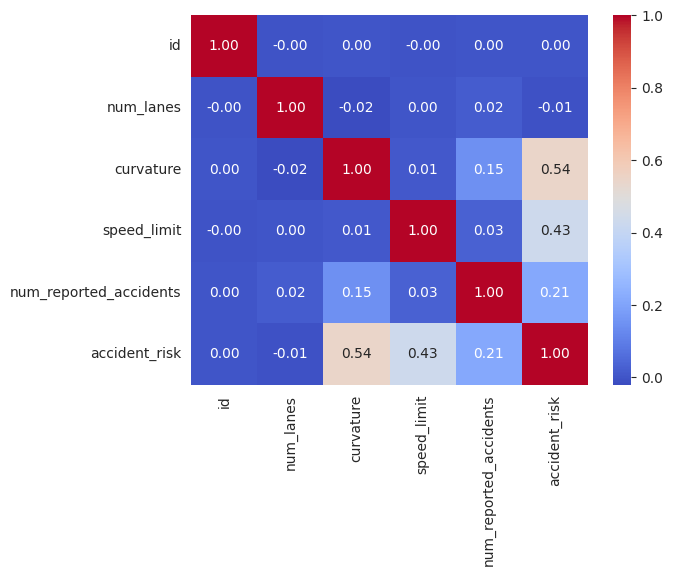

In [12]:
matrix = X[numerical_columns].corr()
sns.heatmap(matrix, annot = True, cmap="coolwarm", fmt = ".2f")

<Axes: >

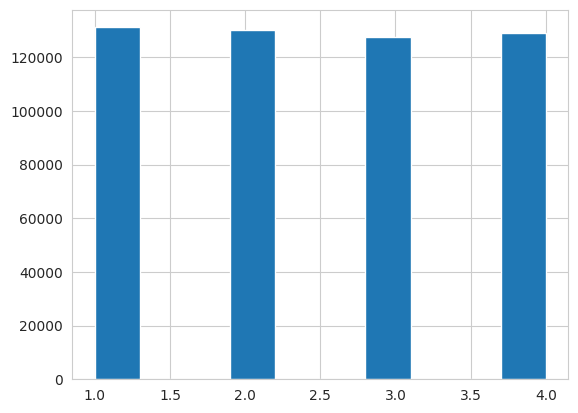

In [13]:
X["num_lanes"].hist()

Text(0.5, 1.0, 'Distribution of accident risk according to lane number')

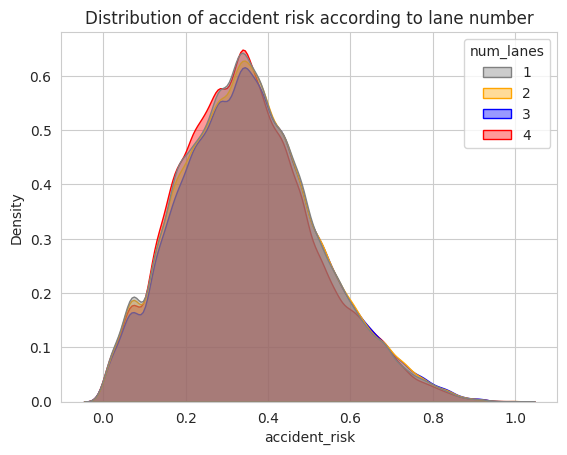

In [14]:
sns.kdeplot(
    data=X,
    x="accident_risk",
    hue="num_lanes",
    palette={1: "grey", 2: "orange", 3: "blue", 4 :"red"},
    fill=True,
    alpha=0.4
)
plt.title("Distribution of accident risk according to lane number")

# Data Preprocessing/ Feature Engineering

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [16]:
X.drop(columns = ["id"],inplace = True)

In [17]:
X["curvature_x_speed_limit"] = X["curvature"] * X["speed_limit"] 
X["curvature**2"] = X["curvature"] ** 2
X["curvature**3"] = X["curvature"] ** 3
X["num_reported_accidents**2"] = X["num_reported_accidents"] ** 2
X["num_reported_accidents**3"] = X["num_reported_accidents"] ** 3



test_data["curvature_x_speed_limit"] = test_data["curvature"] * test_data["speed_limit"] 
test_data["curvature**2"] = test_data["curvature"] ** 2
test_data["curvature**3"] = test_data["curvature"] ** 3
test_data["num_reported_accidents**2"] = test_data["num_reported_accidents"] ** 2
test_data["num_reported_accidents**3"] = test_data["num_reported_accidents"] ** 3

In [18]:
X

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curvature_x_speed_limit,curvature**2,curvature**3,num_reported_accidents**2,num_reported_accidents**3
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,2.10,0.0036,0.000216,1,1
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,34.65,0.9801,0.970299,0,0
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,44.10,0.3969,0.250047,4,8
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,2.45,0.0049,0.000343,1,1
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,34.80,0.3364,0.195112,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32,7.00,0.0100,0.001000,4,8
517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26,16.45,0.2209,0.103823,1,1
517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19,15.50,0.3844,0.238328,0,0
517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51,15.75,0.3969,0.250047,9,27


In [19]:
# FEATURE ENGINEERING
def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = scipy.stats.norm.cdf(a), scipy.stats.norm.cdf(b)
        phi_a, phi_b = scipy.stats.norm.pdf(a), scipy.stats.norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f

train = clip(f)(X)
test = clip(f)(test_data)

X['score'] = train
test_data['score']  = test

X

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curvature_x_speed_limit,curvature**2,curvature**3,num_reported_accidents**2,num_reported_accidents**3,score
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,2.10,0.0036,0.000216,1,1,0.118153
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,34.65,0.9801,0.970299,0,0,0.297000
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,44.10,0.3969,0.250047,4,8,0.389000
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,2.45,0.0049,0.000343,1,1,0.121128
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,34.80,0.3364,0.195112,1,1,0.474000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32,7.00,0.0100,0.001000,4,8,0.330000
517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26,16.45,0.2209,0.103823,1,1,0.241000
517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19,15.50,0.3844,0.238328,0,0,0.286000
517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51,15.75,0.3969,0.250047,9,27,0.489000


In [20]:
categorical_columns = X.select_dtypes(exclude = "number").columns

In [21]:
label_encoder = {}
for col in categorical_columns: 
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoder[col] = le
X

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curvature_x_speed_limit,curvature**2,curvature**3,num_reported_accidents**2,num_reported_accidents**3,score
0,2,2,0.06,35,0,2,0,1,0,0,1,1,0.13,2.10,0.0036,0.000216,1,1,0.118153
1,2,4,0.99,35,0,0,1,0,1,1,1,0,0.35,34.65,0.9801,0.970299,0,0,0.297000
2,1,4,0.63,70,1,0,0,1,2,1,0,2,0.30,44.10,0.3969,0.250047,4,8,0.389000
3,0,4,0.07,35,1,2,1,1,2,0,0,1,0.21,2.45,0.0049,0.000343,1,1,0.121128
4,1,1,0.58,60,0,1,0,0,1,1,0,1,0.56,34.80,0.3364,0.195112,1,1,0.474000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,0,4,0.10,70,0,1,1,1,0,0,0,2,0.32,7.00,0.0100,0.001000,4,8,0.330000
517750,1,4,0.47,35,0,2,1,1,2,0,0,1,0.26,16.45,0.2209,0.103823,1,1,0.241000
517751,2,4,0.62,25,0,1,0,0,0,0,1,0,0.19,15.50,0.3844,0.238328,0,0,0.286000
517752,0,3,0.63,25,2,0,1,0,0,1,1,3,0.51,15.75,0.3969,0.250047,9,27,0.489000


In [22]:
for col in categorical_columns:
    test_data[col] = label_encoder[col].transform(test_data[col])

# Split Data

In [23]:
X_train, X_test,y_train, y_test = train_test_split(X.drop(columns = ["accident_risk"]),X[["accident_risk"]], test_size = 0.2)

# LightGBM

In [24]:
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1,
    'random_state': 42,
    'force_col_wise': True  
}

In [25]:
 param_grid = {
    'n_estimators': [1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 10],
    'num_leaves': [63, 127],
    'min_child_samples': [50, 100],
}

In [26]:
lgbm = lgb.LGBMRegressor(**base_params)

In [27]:
grid_search = GridSearchCV(
    estimator = lgbm,
    param_grid = param_grid,
    cv = 3,
    scoring = "neg_root_mean_squared_error",
    n_jobs = 1,
    verbose = 2,
    return_train_score=True
)

In [28]:
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=63; total time=  22.4s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=63; total time=  21.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=63; total time=  21.7s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=127; total time=  25.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=127; total time=  25.8s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=127; total time=  25.8s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1500, num_leaves=63; total time=  30.6s
[CV] END learning_rate=0.01, max_depth=7, min_child_samples=50, n_estimators=1500, num_leaves=63; total time=  30.6s

GridSearchCV(cv=3,
             estimator=LGBMRegressor(device='gpu', force_col_wise=True,
                                     gpu_device_id=0, gpu_platform_id=0,
                                     metric='rmse', objective='regression',
                                     random_state=42, verbose=-1),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [7, 10], 'min_child_samples': [50, 100],
                         'n_estimators': [1000, 1500],
                         'num_leaves': [63, 127]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [29]:
print(f"\nBest parameters:\n{grid_search.best_params_}")
print(f"\nBest CV RMSE: {-grid_search.best_score_:.6f}")


Best parameters:
{'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 127}

Best CV RMSE: 0.056052


Best parameters:
{'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 127}

Best CV RMSE: 0.056052

In [30]:
best_lgbmodel = grid_search.best_estimator_

In [31]:
y_pred_train = best_lgbmodel.predict(X_train)
y_pred_test = best_lgbmodel.predict(X_test)

In [32]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"Train RMSE: {train_rmse:.6f}")
print(f"Test RMSE:  {test_rmse:.6f}")
print(f"Train R²:   {train_r2:.6f}")
print(f"Test R²:    {test_r2:.6f}")


FINAL MODEL PERFORMANCE
Train RMSE: 0.055318
Test RMSE:  0.056170
Train R²:   0.889490
Test R²:    0.886146


In [33]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgbmodel.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 60)
print("TOP 10 FEATURE IMPORTANCES")
print("=" * 60)
print(feature_importance.head(10).to_string(index=False))


TOP 10 FEATURE IMPORTANCES
                feature  importance
                  score       24753
curvature_x_speed_limit       17202
              curvature        8491
           curvature**2        8106
                weather        7304
              num_lanes        7002
           curvature**3        6750
 num_reported_accidents        5461
            speed_limit        5341
            public_road        5124


# COMPETITION SUBMISSION

In [34]:
test_id = test_data['id']
test_data = test_data.drop(columns=['id'])

In [35]:
pred = best_lgbmodel.predict(test_data)

In [36]:
submission = pd.DataFrame({
        'id': test_id,
        'accident_risk': pred
    })

In [37]:
submission.shape

(172585, 2)

In [38]:
submission.to_csv("Road_Accident_Risk_submission.csv", index = False)